# Task 1

In [1]:
from tensorflow import keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os

from random import shuffle
from skimage.io import imread
from skimage.transform import resize


def gen_labels(im_name, class_list):
    '''

    Parameters
    ----------
    im_name : Str
        The image file name.
    pat1 : Str
        A string pattern in the filename for 1st class, e.g "Mel"
    pat2 : Str
        A string pattern in the filename 2nd class, e.g, "Nev"

    Returns
    -------
    Label : Numpy array
        Class label of the filename name based on its pattern.
    '''
    label = [class_idx for class_idx,class_name in enumerate(class_list) if class_name in im_name]
    return label[0]


def get_data(data_path, data_list, img_h, img_w, class_list):
    """

    Parameters
    ----------
    train_data_path : Str
        Path to the data directory
    train_list : List
        A list containing the name of the images.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.

    Returns
    -------
    img_labels : Nested List
        A nested list containing the loaded images along with their
        correcponding labels.
    """
    img_labels = []

    for item in enumerate(data_list):

        if os.path.isdir(os.path.join(data_path,item[1])):
            image_list = os.listdir(os.path.join(data_path,item[1]))
            for image in enumerate(image_list):
                img = imread(os.path.join(data_path, item[1], image[1]), as_gray=True)  # "as_grey"
                img = resize(img, (img_h, img_w), anti_aliasing=True).astype('float32')
                img_labels.append([np.array(img), gen_labels(item[1], class_list)])
                
                if image[0] % 100 == 0:
                    print('Reading: {0}/{1}  of train images'.format(image[0], len(image_list)))
        else:
            img = imread(os.path.join(data_path, item[1]), as_gray=True)  # "as_grey"
            img = resize(img, (img_h, img_w), anti_aliasing=True).astype('float32')
            img_labels.append([np.array(img), gen_labels(item[1], class_list)])

            if item[0] % 100 == 0:
                print('Reading: {0}/{1}  of train images'.format(item[0], len(data_list)))

    shuffle(img_labels)
    return img_labels


def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
        nested list of image arrays with corresponding class labels.
    img_h : Int
        Image height.
    img_w : Int
        Image width.

    Returns
    -------
    img_arrays : Numpy array
        4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
        1D array with the size (n_data).

    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype=np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype=np.int32)
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    img_arrays = np.expand_dims(img_arrays, axis=3)
    return img_arrays, label_arrays


def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w, class_list):
    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """

    train_data = get_data(train_data_path, train_list, img_h, img_w, class_list)
    test_data = get_data(test_data_path, test_list, img_h, img_w, class_list)

    train_img, train_label = get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del (train_data)
    del (test_data)
    return train_img, test_img, train_label, test_label


In [4]:
# Data and model parameters
img_ch, img_width, img_height = 1, 128, 128

data_path = '/DL_course_data/Lab2/Skin'  # Path to data root with two subdirs.

class_list = ['Mel','Nevi']

train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'validation')


train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)

x_train, x_test, y_train, y_test = get_train_test_arrays(
    train_data_path, test_data_path,
    train_list, test_list, img_height, img_width, class_list)

Reading: 0/500  of train images
Reading: 100/500  of train images
Reading: 200/500  of train images
Reading: 300/500  of train images
Reading: 400/500  of train images
Reading: 0/500  of train images
Reading: 100/500  of train images
Reading: 200/500  of train images
Reading: 300/500  of train images
Reading: 400/500  of train images
Reading: 0/100  of train images
Reading: 0/100  of train images


In [28]:
n_epochs = 150
batch_s = 8
n_base = 8
learn_r = 0.00001

In [32]:
def model(img_ch, img_width, img_height, n_base):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

In [33]:
MLP = model(img_ch, img_width, img_height, n_base)         # Model Instantiating
MLP.compile(loss = 'binary_crossentropy',          # Model Compiling   
              optimizer = Adam(lr = learn_r),
              metrics = ['binary_accuracy'])

History = MLP.fit(x_train, y_train, batch_size = batch_s,
                  validation_data = (x_test, y_test),
                  epochs = n_epochs, verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 128, 128, 8)       80        
                                                                 
 activation_64 (Activation)  (None, 128, 128, 8)       0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 16)        1168      
                                                                 
 activation_65 (Activation)  (None, 64, 64, 16)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                 

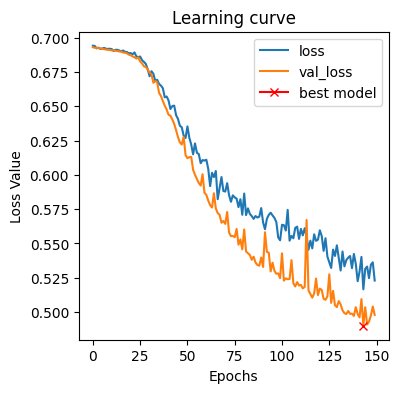

In [34]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(History.history["loss"], label="loss")
plt.plot(History.history["val_loss"], label="val_loss")
plt.plot( np.argmin(History.history["val_loss"]),
         np.min(History.history["val_loss"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

# Task 2

In [46]:
def model(img_ch, img_width, img_height, n_base):
    
    model = Sequential()
    
    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # model.add(SpatialDropout2D(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # model.add(SpatialDropout2D(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # model.add(SpatialDropout2D(0.1))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # model.add(SpatialDropout2D(0.1))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    # model.add(SpatialDropout2D(0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()   
    return model

In [47]:
n_epochs = 250
batch_s = 8
n_base = 32
learn_r = 0.00001
MLP = model(img_ch, img_width, img_height, n_base)         # Model Instantiating
MLP.compile(loss = 'binary_crossentropy',          # Model Compiling   
              optimizer = Adam(lr = learn_r),
              metrics = ['binary_accuracy'])

History = MLP.fit(x_train, y_train, batch_size = batch_s,
                  validation_data = (x_test, y_test),
                  epochs = n_epochs, verbose=1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 activation_96 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 activation_97 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                

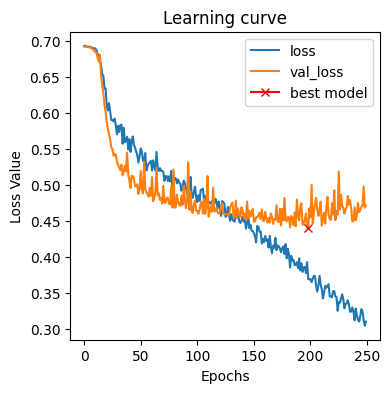

In [48]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(History.history["loss"], label="loss")
plt.plot(History.history["val_loss"], label="val_loss")
plt.plot( np.argmin(History.history["val_loss"]),
         np.min(History.history["val_loss"]),
         marker="x", color="r", label="best model")

plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()